# Import libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [3]:
from alinemol.preprocessing import standardize_smiles, drop_duplicates
from alinemol.utils.split_utils import get_scaffold

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)

import datamol as dm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


In [4]:
#light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
#dark_color = "black"


#matplotlib.use("pgf")


matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 14,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "legend.loc": "upper right",
    }
)

sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)

# Standardize the dataset

In [ ]:
mol_file = os.path.join(DATASET_PATH, "CHEMBL", "CHEMBL1614280", "CHEMBL1614280_simplified.csv")
mol_df = pd.read_csv(mol_file)
print(mol_df.shape)

In [ ]:
mol_df = standardize_smiles(mol_df)
print(mol_df.shape)

In [ ]:
mol_df = drop_duplicates(mol_df)
print(mol_df.shape)

In [7]:
df = mol_df[["canonical_smiles", "label"]]
df.columns = ["smiles", "label"]

df.to_csv(os.path.join(DATASET_PATH, "CHEMBL", "CHEMBL1614280", "CHEMBL1614280_standardize.csv"), index=False)

In [ ]:
mol_df[mol_df['canonical_smiles'].duplicated()]

In [6]:
X = np.array(mol_df["smiles"])
y = np.array(mol_df["label"])

In [12]:
scaf = [get_scaffold(smi) for smi in X]

In [ ]:
## chosse 6 random structure and corresponding scaffold
np.random.seed(7)
idx = np.random.choice(len(X), 6)
mols = [Chem.MolFromSmiles(X[i]) for i in idx]
scafs = [Chem.MolFromSmiles(scaf[i]) for i in idx]

## draw the molecules and their scaffolds
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img

In [ ]:
# Draw scaffold
img_scaf = Draw.MolsToGridImage(scafs, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img_scaf

In [6]:
dataset_category="MoleculeNet"
dataset_names="HIV"
dataset = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_simplified" + ".csv"))

In [ ]:
dataset

In [ ]:
dataset['smiles'].duplicated().sum()

In [ ]:
new_df = standardize_smiles(dataset)

In [ ]:
new_df

In [ ]:
new_df['canonical_smiles'].isna().sum()

In [12]:
new_df = new_df.dropna(subset=['canonical_smiles'])
new_df = new_df[["canonical_smiles", "label"]]
new_df.columns = ["smiles", "label"]

In [14]:
new_df.to_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_processed" + ".csv"), index=False)

In [ ]:
new_df[new_df['smiles'].duplicated()]

In [32]:
dff = new_df[new_df.groupby('smiles').label.transform('nunique') == 1]

In [40]:
dff=dff.drop_duplicates(subset=['smiles'], keep='first')

In [42]:
dff.reset_index(drop=True, inplace=True)

In [ ]:
dff.label.value_counts()

In [ ]:
new_df.groupby('smiles').label.nunique()>1

In [ ]:
new_df.groupby('smiles').label.transform('nunique')

In [3]:
x  = ['CC', 'CC', 'CC', 'CCC', 'CCC', 'CCCC', 'CCCCC', 'CCCCC']
label= [1, 1, 0, 1, 1, 1, 1, 0]
df = pd.DataFrame({'smiles': x, 'label': label})
df = standardize_smiles(df)

In [ ]:
df = df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [ ]:
drop_duplicates(df)['label'].nunique()

In [7]:
mol_df = mol_df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [8]:
import splito
from splito import *

In [14]:
def splits_scaffold(test_dataset_dili, make_generic):
    smiles = test_dataset_dili["smiles"].values
    splitter = ScaffoldSplit(smiles, n_splits=5, make_generic=make_generic, test_size=None)
    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_scfs = set([get_scaffold(smiles[i], make_generic=make_generic) for i in train_ind])
        print(len(train_scfs))
        test_scfs = [get_scaffold(smiles[i], make_generic=make_generic) for i in test_ind]
        print(len(test_scfs))
        print(len(set(test_scfs)))
        print(test_scfs[0])
        assert not any(test_scf in train_scfs for test_scf in test_scfs)

In [ ]:
splits_scaffold(mol_df, make_generic=False)

In [63]:
import datamol as dm

In [76]:
def splits_molecular_weight(test_dataset_dili, generalize_to_larger):
    smiles = test_dataset_dili["smiles"].values
    splitter = MolecularWeightSplit(generalize_to_larger=generalize_to_larger, n_splits=2, test_size=0.1)

    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > len(test_ind)
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_mws = [dm.descriptors.mw(dm.to_mol(smi)) for smi in smiles[train_ind]]
        if generalize_to_larger:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) >= max(train_mws) for smi in smiles[test_ind]
            )
        else:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) <= min(train_mws) for smi in smiles[test_ind]
            )

In [82]:
from splito import MaxDissimilaritySplit

In [9]:
def test_splits_max_dissimilar_default_feats(test_dataset_smiles):
    splitter = MaxDissimilaritySplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0

In [ ]:
mol_df

In [11]:
smiles = mol_df["smiles"].values

In [ ]:
test_splits_max_dissimilar_default_feats(smiles)

In [87]:
from splito import PerimeterSplit


def test_splits_perimeter(test_dataset_smiles):
    splitter = PerimeterSplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        assert splitter._metric == "jaccard"

In [90]:
splitter = PerimeterSplit(n_splits=2)

In [ ]:
splitter

In [ ]:
splitter = PerimeterSplit(n_splits=2)

for train_ind, test_ind in splitter.split(smiles):
    assert len(train_ind) + len(test_ind) == len(smiles)
    assert len(set(train_ind).intersection(set(test_ind))) == 0
    assert len(train_ind) > 0 and len(test_ind) > 0
    assert splitter._metric == "jaccard"

In [ ]:
splits_molecular_weight(mol_df, generalize_to_larger=True)

In [ ]:
## aplly all the splitter that are available in splito on the moldf dataset and create train and test index
splitter = splito.MolecularWeightSplit(test_size=0.2, generalize_to_larger=True)
train_idx, test_idx = next(splitter.split(X=mol_df.smiles.tolist()))
assert train_idx.shape[0] > test_idx.shape[0]

In [22]:
mol_df.loc[train_idx, "MolecularWeightSplit"] = "train"
mol_df.loc[test_idx, "MolecularWeightSplit"] = "test"

In [23]:
import datamol as dm

In [24]:
mol_df["mw"] = mol_df.smiles.apply(lambda smi: dm.descriptors.mw(dm.to_mol(smi)))

In [ ]:
mol_df.groupby(by="MolecularWeightSplit")["mw"].hist(legend=True)

In [42]:
mol_df =mol_df[-mol_df.duplicated()]

In [ ]:
from alinemol.utils.split_utils import get_scaffold
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold"] = get_scaffold(mol_df.loc[idx, "smiles"])

In [ ]:
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold_generic"] = get_scaffold(mol_df.loc[idx, "smiles"], make_generic=True)

In [ ]:
mol_df['scaffold_generic'].nunique()

In [83]:
dataset_category="MoleculeNet"
dataset_names="HIV"
split_type="scaffold"
filename="external_test_balanced.csv"
train_filename="train_balanced.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

In [84]:
external_test = pd.read_csv(os.path.join (SPLIT_PATH, split_type, filename))
train = pd.read_csv(os.path.join (SPLIT_PATH, split_type, train_filename))
df = pd.concat([external_test, train])

In [78]:
#df= pd.read_csv("datasets/TDC/CYP3A4/CYP3A4_simplified.csv")

In [85]:
train_scaf = [get_scaffold(smi) for smi in train["smiles"]]
external_test_scaf = [get_scaffold(smi) for smi in external_test["smiles"]]
df_scaf = [get_scaffold(smi) for smi in df["smiles"]]


In [ ]:
pd.Series(df_scaf).value_counts(sort=False).plot(kind='bar')

In [ ]:
fis, ax=plt.subplots(1, 3, figsize=(15, 5))
pd.Series(train_scaf).value_counts(sort=False).plot(kind='bar', ax=ax[0])

In [86]:
df_scaf_uni = list(set(df_scaf))

In [ ]:
#plot hist of df_scaf
from collections import Counter
#a=Counter(df_scaf)
#print(a)
import matplotlib.pyplot as plt
plt.hist(np.array(df_scaf), bins=10)
#plt.show()

In [ ]:
print(len(df_scaf_uni))
print(df.shape)
print(len(df_scaf_uni)/df.shape[0])

In [ ]:
train_scaf_uni = list(set(train_scaf))
external_test_scaf_uni = list(set(external_test_scaf))

print(len(train_scaf_uni))
print(len(train_scaf_uni)/train.shape[0])
print(len(external_test_scaf_uni))
print(len(external_test_scaf_uni)/external_test.shape[0])

print(set(train_scaf_uni).intersection(set(external_test_scaf_uni)))

# Dataset (train/test) charactersitics

## Train and Test Active percentage

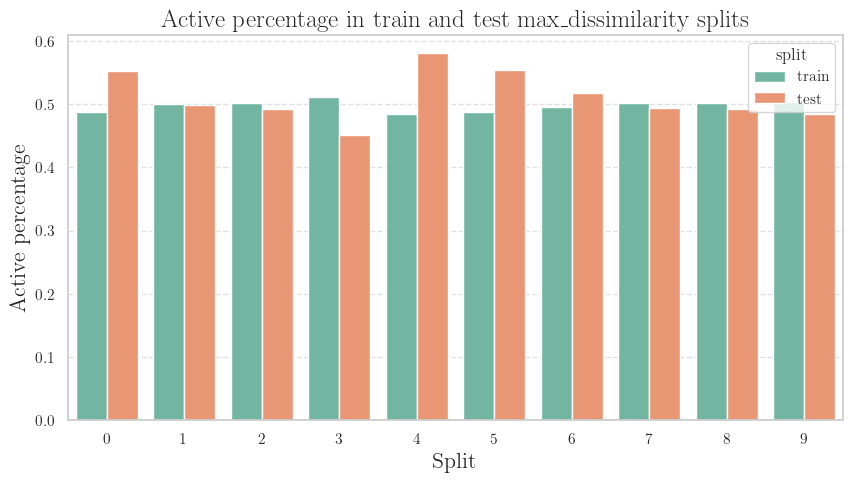

In [176]:
dataset_category="TDC"
dataset_names="HERG"
split_type="max_dissimilarity"

active_train= []
active_test = []
dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

with open(os.path.join(dataset_folder, "config.json"), "r") as f:
    data_config = json.load(f)

for i in range(10):
    active_train.append(data_config[f"train_actives_percentage_{i}"])
    active_test.append(data_config[f"test_actives_percentage_{i}"])

#create df for sns plot
df = pd.DataFrame()
df['split'] = ['train'] *10 + ['test'] *10
df['active'] = active_train + active_test
df['id'] = list(range(10)) * 2

#plot active train vs active test as a bar plot in the same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='id', y='active', data=df, ax=ax, hue='split')
ax.set_ylabel("Active percentage", fontsize=16)
ax.set_xlabel("Split", fontsize=16)
ax.set_title(f"Active percentage in train and test {split_type} splits", fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Train and Test size

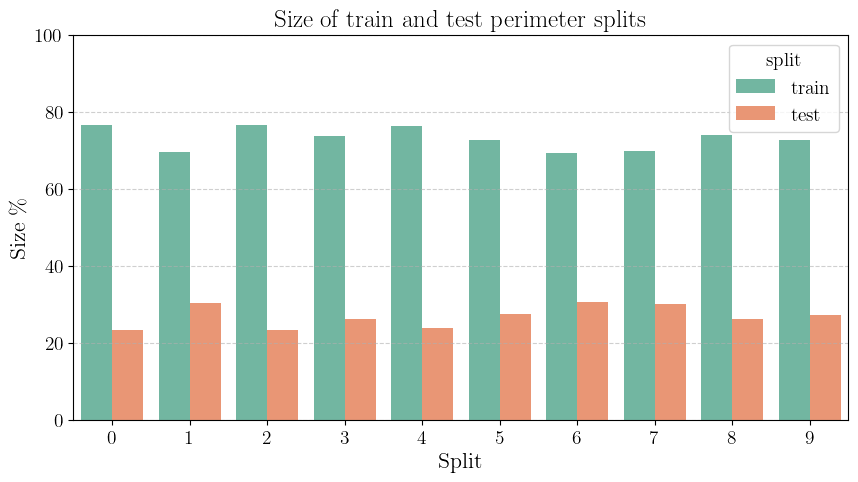

In [31]:
dataset_category="TDC"
dataset_names="CYP2D6"
split_type="perimeter"

train_size= []
test_size = []
dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

with open(os.path.join(dataset_folder, "config.json"), "r") as f:
    data_config = json.load(f)

for i in range(10):
    train_size.append(data_config[f"train_size_{i}"])
    test_size.append(data_config[f"test_size_{i}"])

train_frac =[train_size[i] / (train_size[i] + test_size[i]) * 100 for i in range(10)]
test_frac = [test_size[i] / (train_size[i] + test_size[i]) * 100 for i in range(10)]


#create df for sns plot
df = pd.DataFrame()
df['split'] = ['train'] *10 + ['test'] *10
df['size'] = train_size + test_size
df['size_percentage'] = train_frac + test_frac
df['id'] = list(range(10)) * 2

#plot train and test size as a bar plot in the same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='id', y='size_percentage', data=df, ax=ax, hue='split')
ax.set_ylabel("Size \%", fontsize=16)
ax.set_xlabel("Split", fontsize=16)
ax.set_title(f"Size of train and test {split_type} splits", fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ybound(0, 100)
plt.show()


In [7]:
train_frac

[79.48941568223262,
 79.00578767937841,
 81.09093792119242,
 81.43185602156505,
 82.24847379687624,
 76.96027907714263,
 77.01577737255214,
 77.74518354079125,
 81.18607785618013,
 76.7858558629985]

## Train and Test Molecular Weight

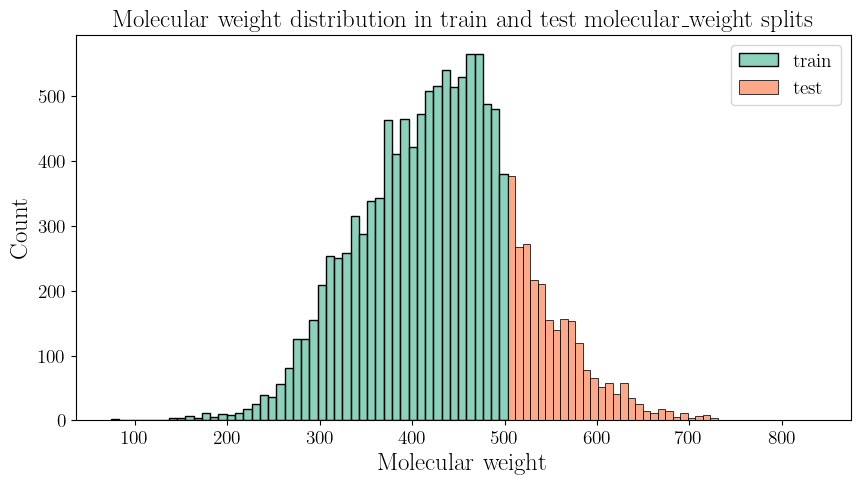

In [59]:
# First, i calculate the molecular weight of each molecule in the dataset in the train and test split.
# Then I plot the distribution of the molecular weight in the train and test split.
split_type="molecular_weight"
dataset_category="TDC"
dataset_names="HERG"

dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

train = pd.read_csv(os.path.join(dataset_folder, "train_0.csv"))
test = pd.read_csv(os.path.join(dataset_folder, "test_0.csv"))

train["mw"] = train["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))
test["mw"] = test["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))

# Plot the histogram of the molecular weight in the train and test split
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(train["mw"], label="train", ax=ax)
sns.histplot(test["mw"], label="test", ax=ax)
ax.set_xlabel("Molecular weight", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title(f"Molecular weight distribution in train and test {split_type} splits", fontsize=18)
ax.legend()
plt.show()

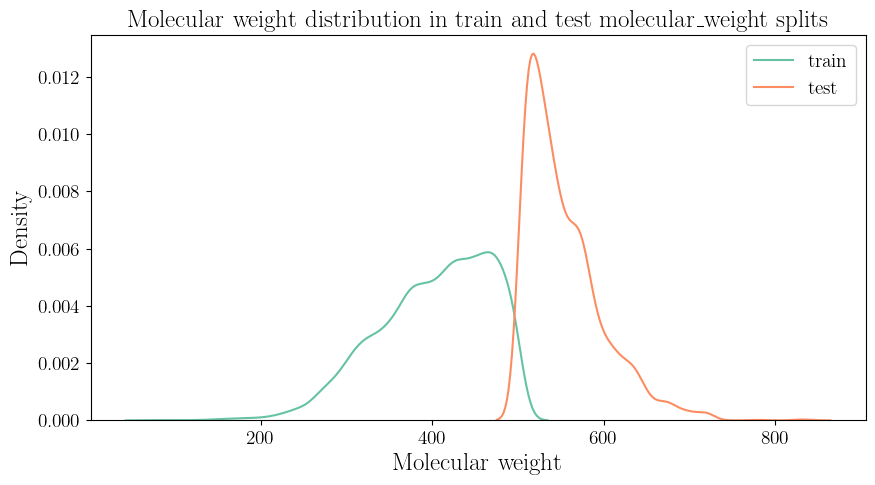

In [60]:
# Plot the distribution of the molecular weight in the train and test split
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(train["mw"], label="train", ax=ax)
sns.kdeplot(test["mw"], label="test", ax=ax)
ax.set_xlabel("Molecular weight", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
ax.set_title(f"Molecular weight distribution in train and test {split_type} splits", fontsize=18)
ax.legend()
plt.show()


In [62]:
#Determine the difference in the molecular weight median between the train and test split
train_mw_median = train["mw"].median()
test_mw_median = test["mw"].median()
mw_diff = test_mw_median - train_mw_median
print(f"The difference in the molecular weight median between the train and test split is: {mw_diff:.2f}")

The difference in the molecular weight median between the train and test split is: 129.04


# Plot performance of ID vs OOD

In [12]:
from alinemol.utils.utils import compute_ID_OOD
split_type="max_dissimilarity"
dataset_name="AMES"
df = compute_ID_OOD(dataset_category="TDC", dataset_names=dataset_name, split_type=split_type, num_of_splits=10)
df.to_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"), index=False)

(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(896, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(866, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(850, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(1064, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(849, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(681, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(891, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874, 2)
(874,

In [153]:
split_type="max_dissimilarity"
results = pd.read_csv(os.path.join("classification_results", "TDC", "HERG", split_type, "results.csv"))

In [154]:
results.shape

(130, 10)

In [155]:
#results = results.drop([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

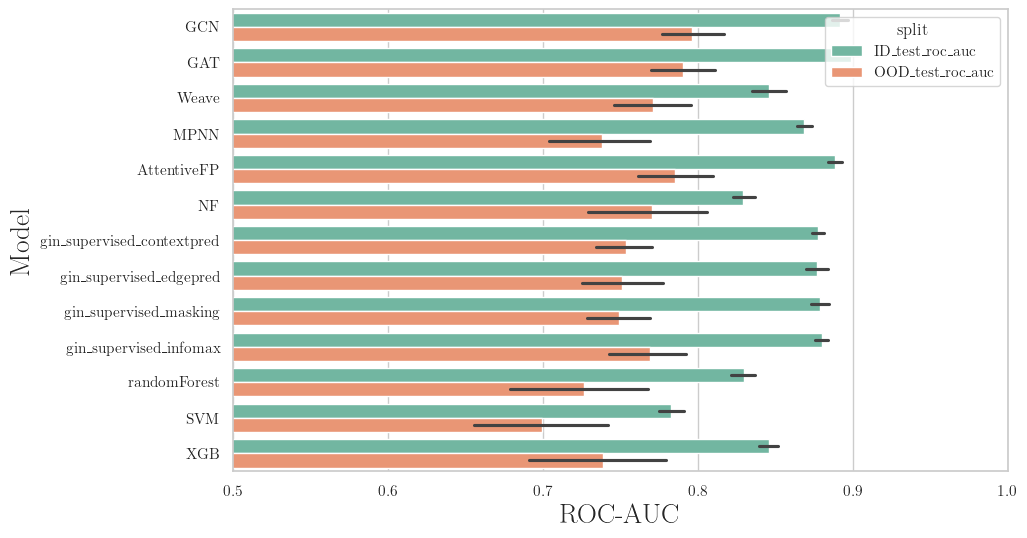

In [156]:
# barplot of the results (ID columns vs OOD Columns) for each model) in seaborn
# change sns font and font size
#sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
sns.set_palette("Set2")

tidy_1 = results.melt(id_vars=["model"], value_vars=["ID_test_accuracy", "OOD_test_accuracy"], var_name="split", value_name="accuracy")
tidy_2 = results.melt(id_vars=["model"], value_vars=["ID_test_roc_auc", "OOD_test_roc_auc"], var_name="split", value_name="roc_auc")
tidy3 = results.melt(id_vars=["model"], value_vars=["ID_test_pr_auc", "OOD_test_pr_auc"], var_name="split", value_name="pr_auc")


fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

sns.barplot(y="model", x="roc_auc", hue="split", data=tidy_2, ax=ax, orient="h")
#sns.barplot(x="model", y="roc_auc", hue="split", data=tidy_2, ax=ax[1])
#sns.barplot(x="model", y="pr_auc", hue="split", data=tidy3, ax=ax[2])
ax.grid(False, axis='y')
ax.set_xlabel("ROC-AUC", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.set_xlim(0.5, 1.0)
plt.show()


In [157]:
results.groupby('model')

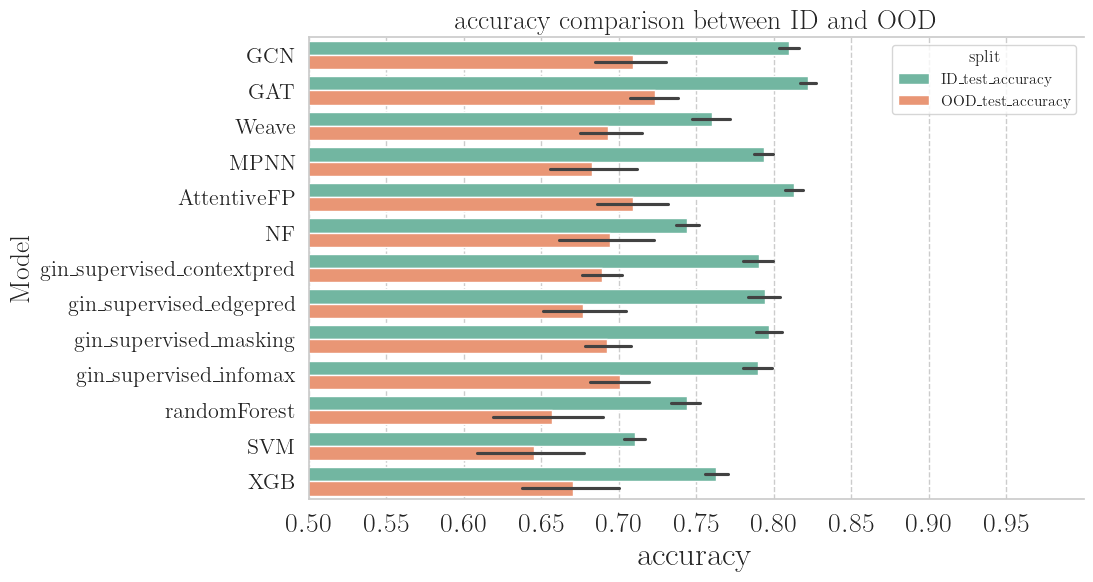

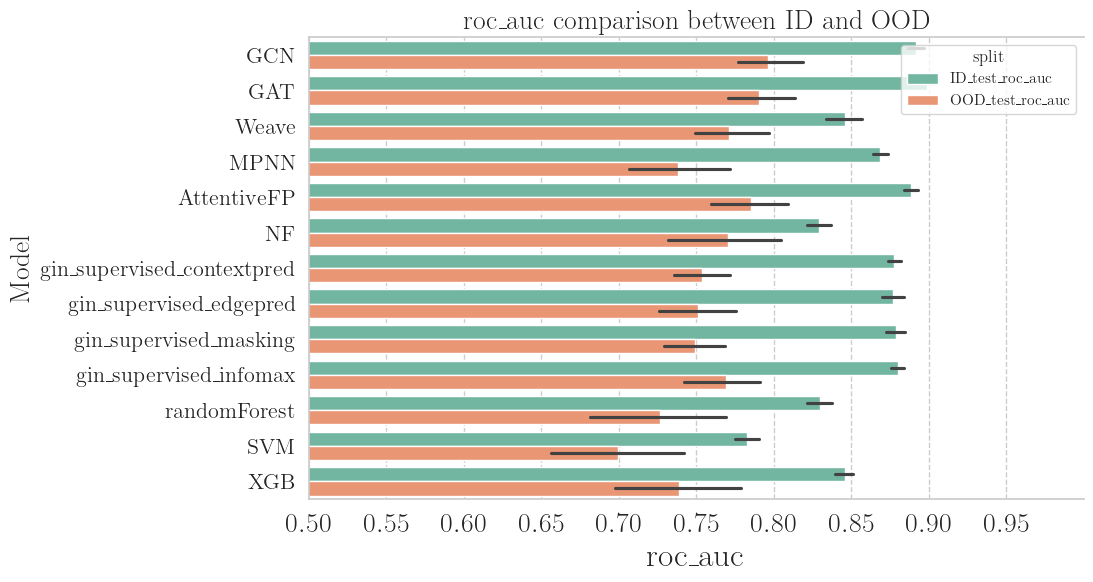

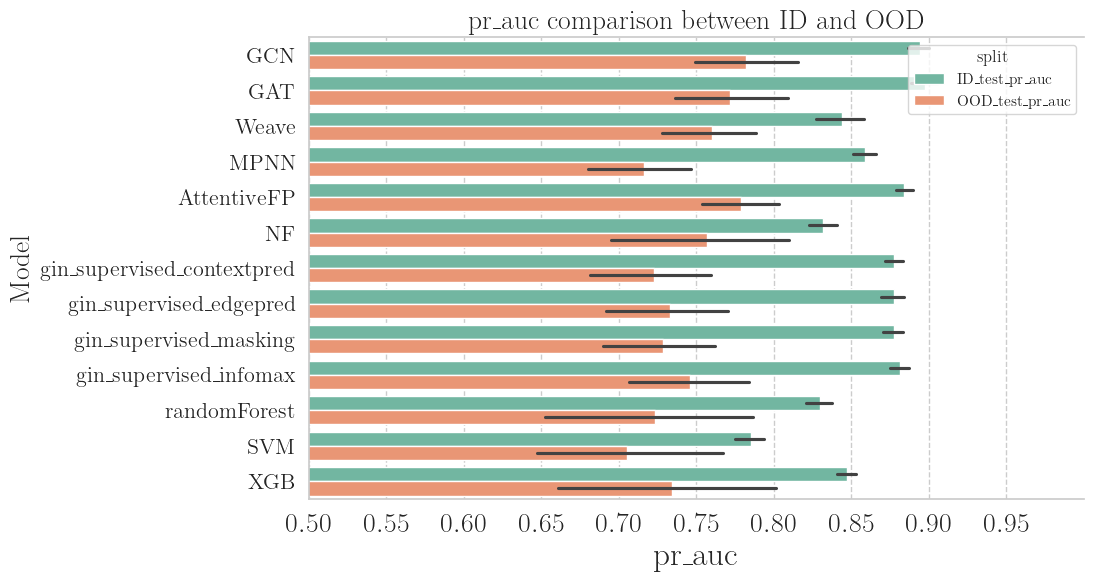

In [158]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
for metric in metrics:
    tidy = results.melt(id_vars=["model"], value_vars=[f"ID_test_{metric}", f"OOD_test_{metric}"], var_name="split", value_name=metric)
    fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
    sns.barplot(y="model", x=metric, hue="split", data=tidy, ax=ax, orient="h")
    ax.grid(True, axis='x', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(metric, fontsize=24)
    ax.set_ylabel("Model", fontsize=20)
    ax.set_xlim(0.5, 1.0)
    ax.set_xticks(np.arange(0.5, 1.0, 0.05))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=16)
    ax.set_title(f"{metric} comparison between ID and OOD", fontsize=20)
    plt.show()

In [159]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
diff = []
for metric in metrics:
    results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
    diff.append(results.groupby('model')[f'diff_{metric}'].mean())

In [160]:
diff = pd.concat(diff, axis=1)

In [161]:
diff

,diff_accuracy,diff_roc_auc,diff_pr_auc
model,,,
AttentiveFP,0.103862,0.103453,0.105599
GAT,0.098417,0.108271,0.125321
GCN,0.100693,0.095829,0.112160
MPNN,0.111257,0.130581,0.142309
NF,0.050110,0.058491,0.074916
SVM,0.065183,0.083593,0.079803
Weave,0.067006,0.074976,0.083861
XGB,0.092142,0.106893,0.112665
gin_supervised_contextpred,0.101216,0.124077,0.155344


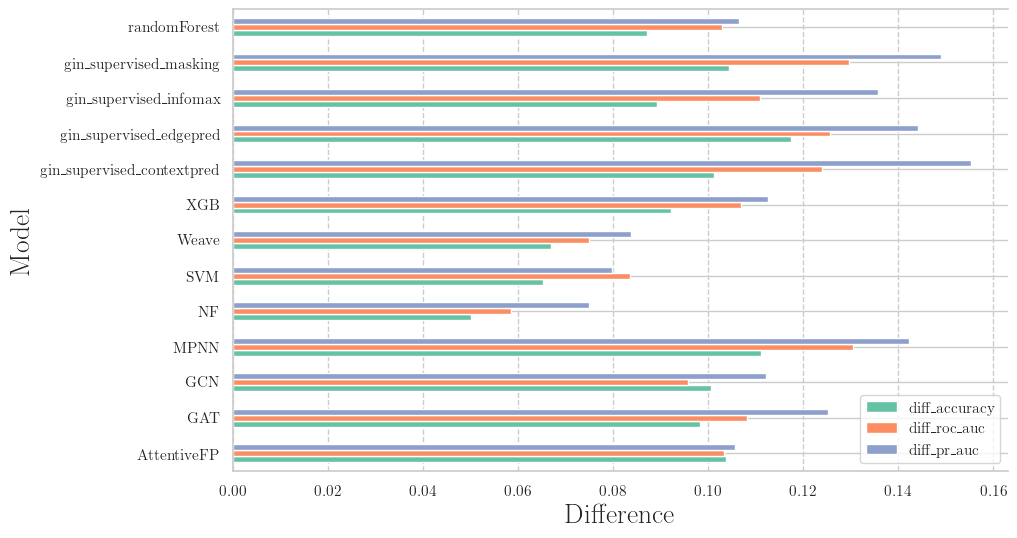

In [162]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
diff.plot(kind='barh', ax=ax)
ax.set_xlabel("Difference", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.grid(True, axis='x', linestyle='--')
ax.spines['right'].set_visible(False)
plt.show()

In [163]:
ML_MODELS = ['randomForest', 'SVM', 'XGB']
GNN_MODELS = ["GCN",
        "GAT",
        "Weave",
        "MPNN",
        "AttentiveFP",
        "NF",]

PRETRAINED_GNN_MODELS = ["gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]

In [164]:
# I want to have diff for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately, and then plot them together
split_type="max_dissimilarity"
dataset_name="HERG"
diff = []
for models in ALL_MODELS:
    results = pd.read_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"))
    results = results[results['model'].isin(models)]
    metrics = ['accuracy', 'roc_auc', 'pr_auc']
    diff_models = []
    for metric in metrics:
        results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
        diff_models.append(results.groupby('model')[f'diff_{metric}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [165]:
diff[0]

,diff_accuracy,diff_roc_auc,diff_pr_auc
model,,,
SVM,0.065183,0.083593,0.079803
XGB,0.092142,0.106893,0.112665
randomForest,0.087114,0.102859,0.106542


In [166]:
diff[0].mean(axis=0) # ML_MODELS
diff[1].mean(axis=0) # GNN_MODELS
diff[2].mean(axis=0) # PRETRAINED_GNN_MODELS

#concat the diff[0], diff[1], and diff[2] and plot them


diff_accuracy    0.103049
diff_roc_auc     0.122566
diff_pr_auc      0.146049
dtype: float64

In [167]:
mean_df = pd.DataFrame([diff[0].mean(axis=0), diff[1].mean(axis=0), diff[2].mean(axis=0)], index=["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"])
mean_df

,diff_accuracy,diff_roc_auc,diff_pr_auc
ML_MODELS,0.081479,0.097782,0.099670
GNN_MODELS,0.088558,0.095267,0.107361
PRETRAINED_GNN_MODELS,0.103049,0.122566,0.146049


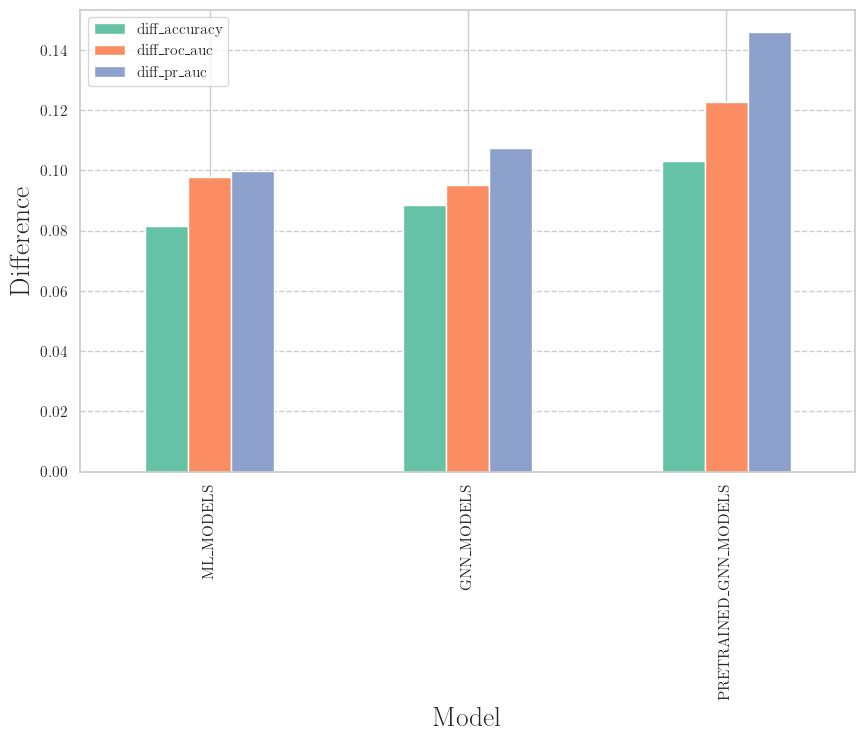

In [168]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
mean_df.plot(kind='bar', ax=ax)
ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Difference", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()


In [29]:
results.groupby('model')['ID_test_roc_auc'].mean() -  results.groupby('model')['OOD_test_roc_auc'].mean()

model
gin_supervised_contextpred    0.059433
gin_supervised_edgepred       0.084723
gin_supervised_infomax        0.073995
gin_supervised_masking        0.079672
dtype: float64

In [30]:
results.groupby('model')['ID_test_pr_auc'].mean() -  results.groupby('model')['OOD_test_pr_auc'].mean()

model
gin_supervised_contextpred    0.218787
gin_supervised_edgepred       0.262459
gin_supervised_infomax        0.230065
gin_supervised_masking        0.221390
dtype: float64

In [31]:
diff

[              diff_accuracy  diff_roc_auc  diff_pr_auc
 model                                                 
 SVM                0.148441      0.113873     0.346518
 XGB                0.195514      0.174043     0.388422
 randomForest       0.192306      0.165081     0.395929,
              diff_accuracy  diff_roc_auc  diff_pr_auc
 model                                                
 AttentiveFP       0.125940      0.101893     0.276711
 GAT               0.118682      0.099836     0.285384
 GCN               0.104489      0.121444     0.338707
 MPNN              0.119461      0.103670     0.296687
 NF                0.093371      0.101720     0.307269
 Weave             0.108286      0.094117     0.276153,
                             diff_accuracy  diff_roc_auc  diff_pr_auc
 model                                                               
 gin_supervised_contextpred       0.028087      0.059433     0.218787
 gin_supervised_edgepred          0.071447      0.084723     0.26245

In [32]:
# grouped bar plot of ID_test_accuracy vs OOD_test_accuracy for each model in the results dataframe alongsilde each other
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
results = results[['model', 'ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']]
results.groupby('model').mean().plot(kind='bar', y=['ID_test_accuracy', 'OOD_test_accuracy'], ax=ax, edgecolor='black', linewidth=1, fontsize=20)
ax.grid(False, axis='x')
ax.set_xlabel("Model", fontsize=24)
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_ylim(0.5, 0.8)

(0.5, 0.8)

In [ ]:
results

In [199]:
dataset_category="TDC"
dataset_names="CYP2D6"
split_types=["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter"]
models = ["GCN", "GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax", "randomForest", "SVM", "XGB"]

## there is result.csv in each of the folder. I want to compine them and concatanate rows of the results
results = []
for split_type in split_types:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, "results.csv")))
results = pd.concat(results)
results.to_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"), index=False)

In [394]:
dataset_category="TDC"
dataset_names="CYP3A4"
results = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"))

In [395]:
# First gropuby by splits and then comute the mean and std of accuarcy, roc_auc and pr_auc colums
dff =results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].agg(['mean', 'std'])

In [ ]:
dff

In [ ]:
results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].mean()

In [ ]:
dff

In [ ]:
results.groupby('split')['test_size'].mean()

In [201]:
# combine results for all the datasets in the TDC folder
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
datasets = cfg["datasets"][dataset_category]
results = []
for dataset in datasets:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset, "results.csv")))

results = pd.concat(results)

results.to_csv(os.path.join("classification_results", dataset_category, "results.csv"), index=False)


In [ ]:
results.groupby('dataset')['ID_test_roc_auc'].mean()

## Analysis of the performance of ID vs OOD

In [21]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))

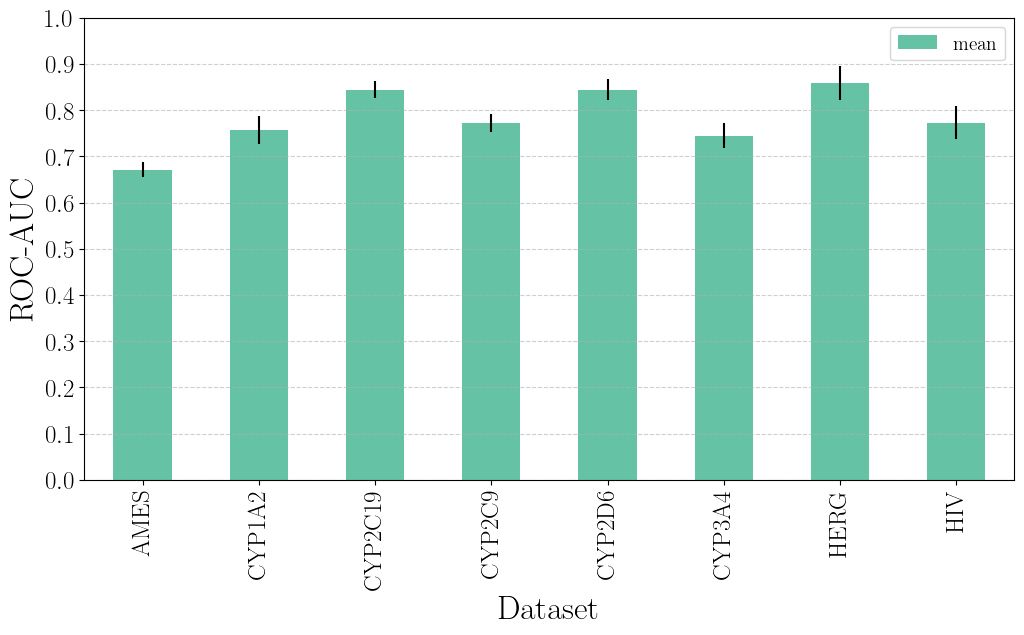

In [7]:
## First, lets have a look on the absolute performance of in distribution on all the datasets. 
## barplot mean and standard deviation of ID_test_roc_auc for each dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metric_mapping = {'ID_test_accuracy': 'Accuracy', 'ID_test_roc_auc': 'ROC-AUC', 'ID_test_pr_auc': 'PR-AUC'}
chosen_metric = 'ID_test_roc_auc'
results.groupby('dataset')[chosen_metric].agg(['mean', 'std']).plot(kind='bar', y='mean', yerr='std', ax=ax, fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xlabel("Dataset", fontsize=24)
ax.set_ylabel(metric_mapping[chosen_metric], fontsize=24)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

In [8]:
## Then lets compare the performance drop for each dataset across each split
results.groupby('dataset')['ID_test_roc_auc'].mean() - results.groupby('dataset')['OOD_test_roc_auc'].mean()

dataset
AMES       0.022177
CYP1A2    -0.019764
CYP2C19    0.041523
CYP2C9     0.045996
CYP2D6     0.025570
CYP3A4     0.006254
HERG       0.107514
HIV        0.025566
dtype: float64

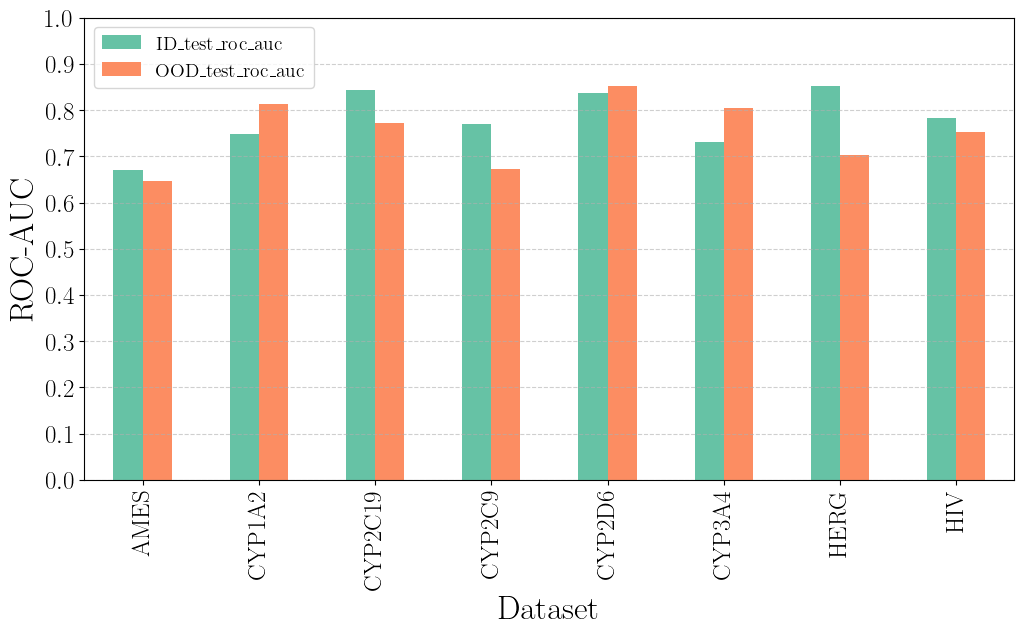

In [22]:
# Just pick the chosen split from all the split in the dataframe
chosen_split = 'max_dissimilarity'
chosen_metric = 'test_roc_auc'
metric_mapping = {'test_accuracy': 'Accuracy', 'test_roc_auc': 'ROC-AUC', 'test_pr_auc': 'PR-AUC'}
df_selected=results[results['split']==chosen_split]

# First, group the results by dataset. then, select ID and OOd performance columns. Then baplot ID and OOd alongside each other
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_selected.groupby('dataset')[[f'ID_{chosen_metric}', f'OOD_{chosen_metric}']].mean().plot(kind='bar', ax=ax, fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xlabel("Dataset", fontsize=24)
ax.set_ylabel(metric_mapping[chosen_metric], fontsize=24)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
plt.show()


In [37]:
print(df_selected.groupby('dataset')['ID_test_roc_auc'].mean() - df_selected.groupby('dataset')['OOD_test_roc_auc'].mean())
# same as above, but percentage drop
print((df_selected.groupby('dataset')['ID_test_roc_auc'].mean() - df_selected.groupby('dataset')['OOD_test_roc_auc'].mean())/df_selected.groupby('dataset')['ID_test_roc_auc'].mean())

dataset
AMES       0.025641
CYP1A2    -0.063760
CYP2C19    0.070043
CYP2C9     0.098193
CYP2D6    -0.015047
CYP3A4    -0.071803
HERG       0.149581
HIV        0.030372
dtype: float64
dataset
AMES       0.038198
CYP1A2    -0.085119
CYP2C19    0.083116
CYP2C9     0.127563
CYP2D6    -0.017957
CYP3A4    -0.098094
HERG       0.175375
HIV        0.038804
dtype: float64


In [36]:
df_selected.groupby('dataset')['OOD_test_roc_auc'].mean()

dataset
AMES       0.645632
CYP1A2     0.812826
CYP2C19    0.772663
CYP2C9     0.671568
CYP2D6     0.852987
CYP3A4     0.803785
HERG       0.703339
HIV        0.752335
Name: OOD_test_roc_auc, dtype: float64

In [25]:
# combine results for all the datasets in the TDC folder
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
ML_MODELS = cfg["models"]["ML"]
GNN_MODELS = cfg["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS = cfg["models"]["GNN"]["pretrained"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]

In [26]:
# I want to plot the dfference bwteen ID and OOD for each model in the ALL_MODELS
diff = []
for models in ALL_MODELS:
    results = df_selected[df_selected['model'].isin(models)].copy()
    metrics = ['accuracy', 'roc_auc', 'pr_auc']
    diff_models = []
    for metric in metrics:
        results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
        diff_models.append(results.groupby('model')[f'diff_{metric}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [27]:
mean_df = pd.DataFrame([diff[0].mean(axis=0), diff[1].mean(axis=0), diff[2].mean(axis=0)], index=["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"])

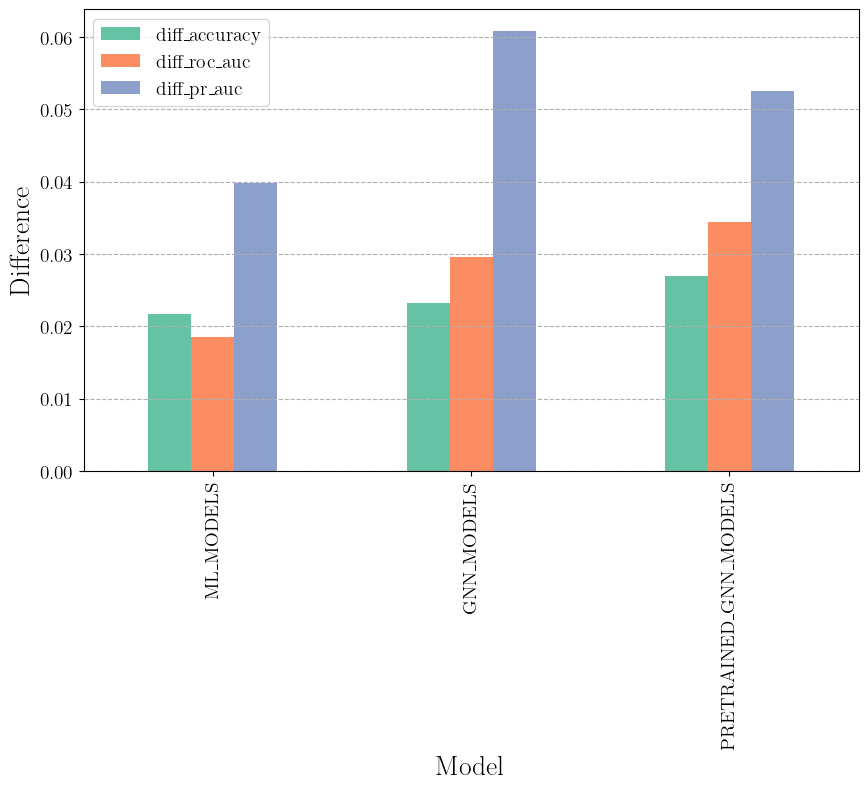

In [28]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
mean_df.plot(kind='bar', ax=ax)
ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Difference", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()

In [32]:
# I want to plot the dfference bwteen ID and OOD for each model in the ALL_MODELS for each dataset separately
diff = []
metrics = 'roc_auc'
percentage = True
for models in ALL_MODELS:
    results = df_selected[df_selected['model'].isin(models)].copy()
    diff_models = []
    if percentage:
        results[f'diff_{metrics}'] = (results[f'ID_test_{metrics}'] - results[f'OOD_test_{metrics}']) / results[f'ID_test_{metrics}'] * 100
    else:
        results[f'diff_{metrics}'] = results[f'ID_test_{metrics}'] - results[f'OOD_test_{metrics}']
    diff_models.append(results.groupby(['model', 'dataset'])[f'diff_{metrics}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [33]:
# for all the datasets, plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
a = pd.DataFrame()
for i in range(3):
    a = pd.concat([a, diff[i].groupby('dataset').mean()], axis=1)
a.columns = ["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"]

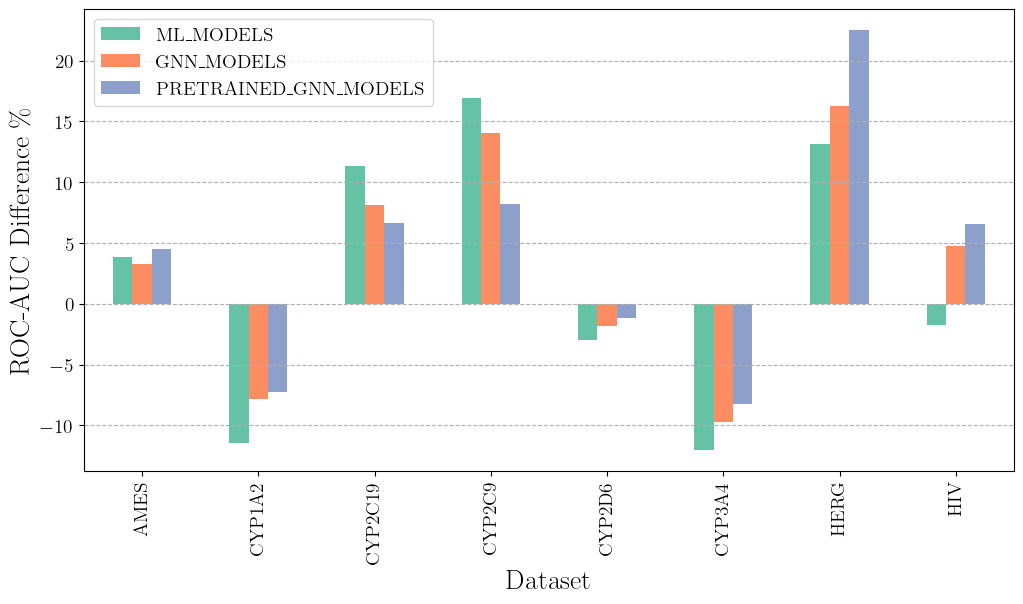

In [34]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=1)
a.plot(kind='bar', ax=ax)
ax.set_xlabel("Dataset", fontsize=20)
ax.set_ylabel("ROC-AUC Difference \%", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()


In [107]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))

In [108]:
# First choose a particular dataset. Then for that dataset, plot the performance for all the differet splitting approaches
dataset_name = "HERG"
df = results[results['dataset']==dataset_name]

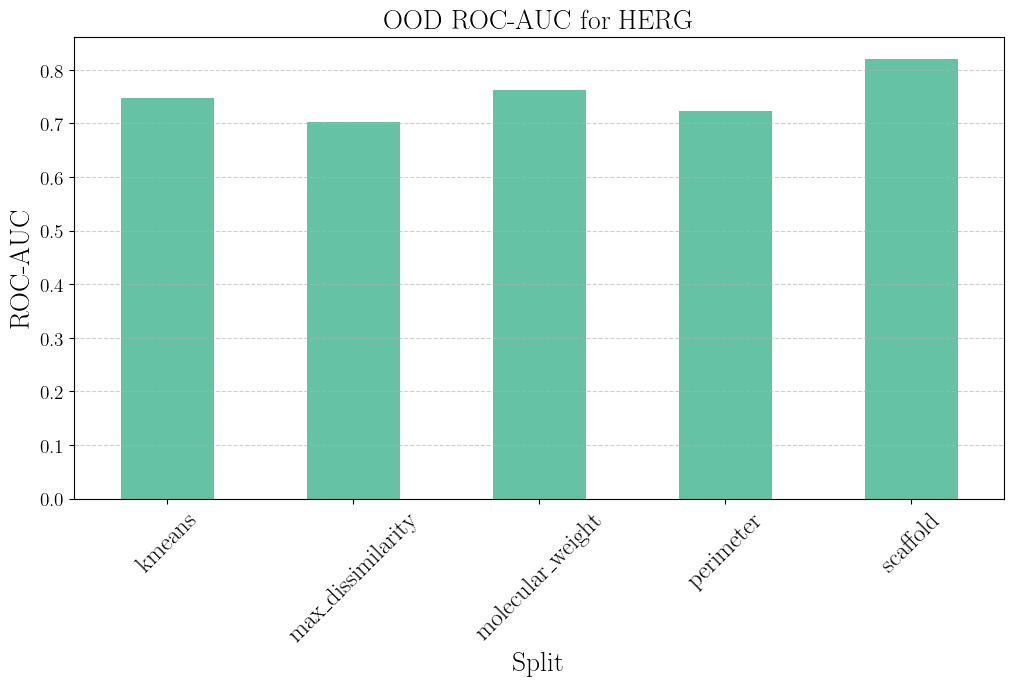

In [110]:
ax, fig = plt.subplots(1, 1, figsize=(12, 6))
df.groupby('split')['OOD_test_roc_auc'].mean().plot(kind='bar')
plt.ylabel("ROC-AUC", fontsize=20)
plt.xlabel("Split", fontsize=20)
plt.title(f"OOD ROC-AUC for {dataset_name}", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


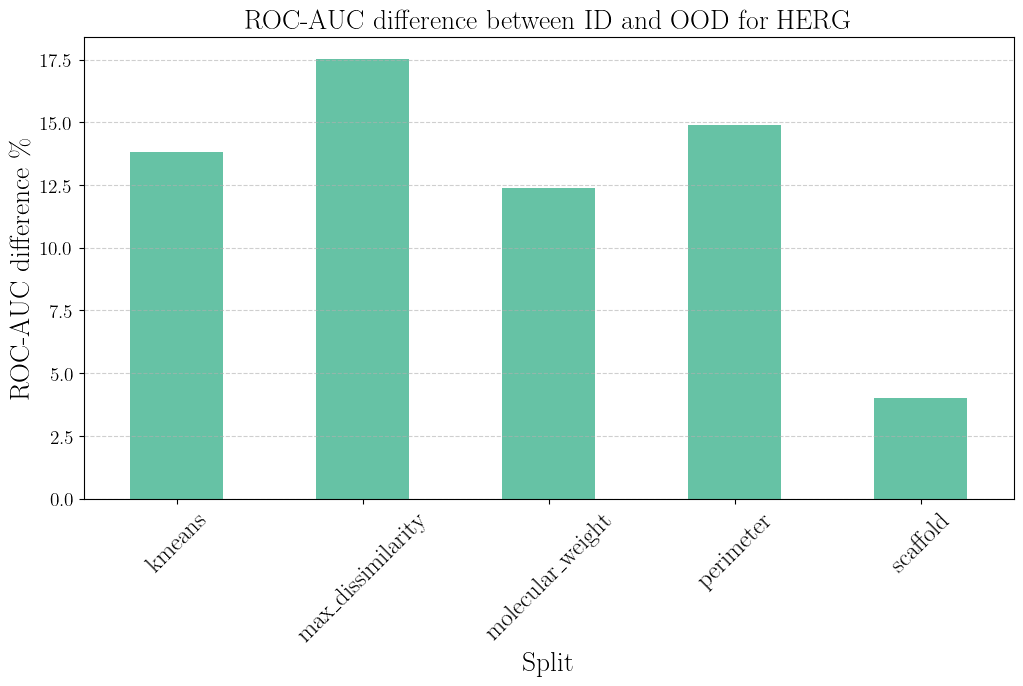

In [112]:
# plot the difference between ID and OOD for the dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
perc = True
if perc:
    a= (df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean())/df.groupby('split')['ID_test_roc_auc'].mean() * 100
    plt.ylabel("ROC-AUC difference \%", fontsize=20)
else:
    a= df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean()
    plt.ylabel("ROC-AUC difference", fontsize=20)
a.plot(kind='bar')
plt.xlabel("Split", fontsize=20)
plt.title(f"ROC-AUC difference between ID and OOD for {dataset_name}", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [59]:
(df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean()).plot(kind='bar')

<Axes: xlabel='split'>

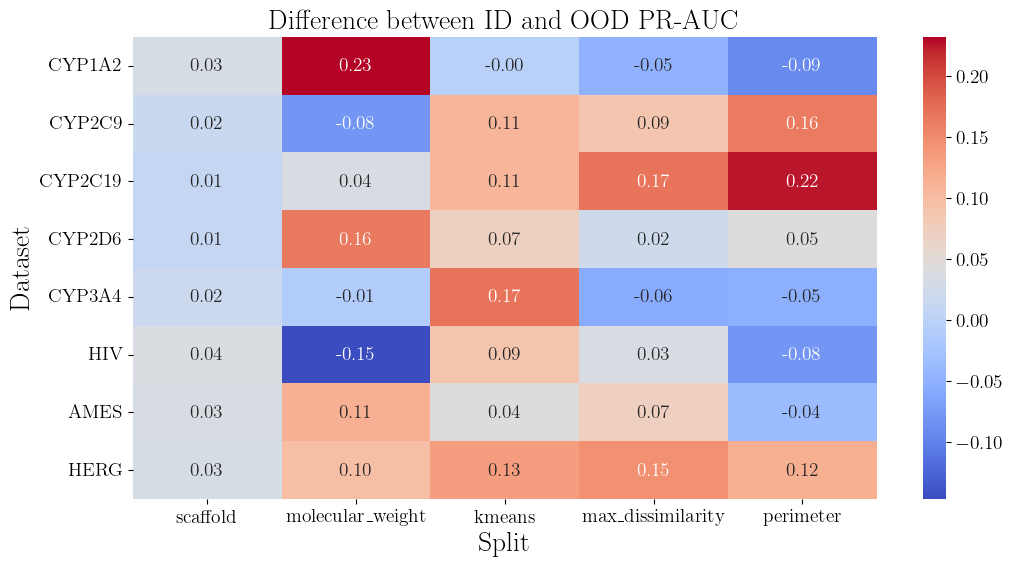

In [91]:
## We want to have a heatmap with one axis datasets and one axis splits. The values in the heatmap are the difference between ID and OOD
## for each dataset and split

results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv")) # read the results
dataset_names = results['dataset'].unique() # get the unique dataset names
split_types = results['split'].unique() # get the unique split types

# create a dataframe to store the difference between ID and OOD for each dataset and split
df = pd.DataFrame(index=dataset_names, columns=split_types)

# fill the dataframe with the difference between ID and OOD for each dataset and split
for dataset in dataset_names:
    for split in split_types:
        df.loc[dataset, split] = results[(results['dataset']==dataset) & (results['split']==split)]['ID_test_pr_auc'].mean() - results[(results['dataset']==dataset) & (results['split']==split)]['OOD_test_pr_auc'].mean()

df = df.astype(float)
# plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.heatmap(df, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
plt.xlabel("Split", fontsize=20)
plt.ylabel("Dataset", fontsize=20)
plt.title("Difference between ID and OOD PR-AUC", fontsize=20)
plt.show() 

# Model Calibration

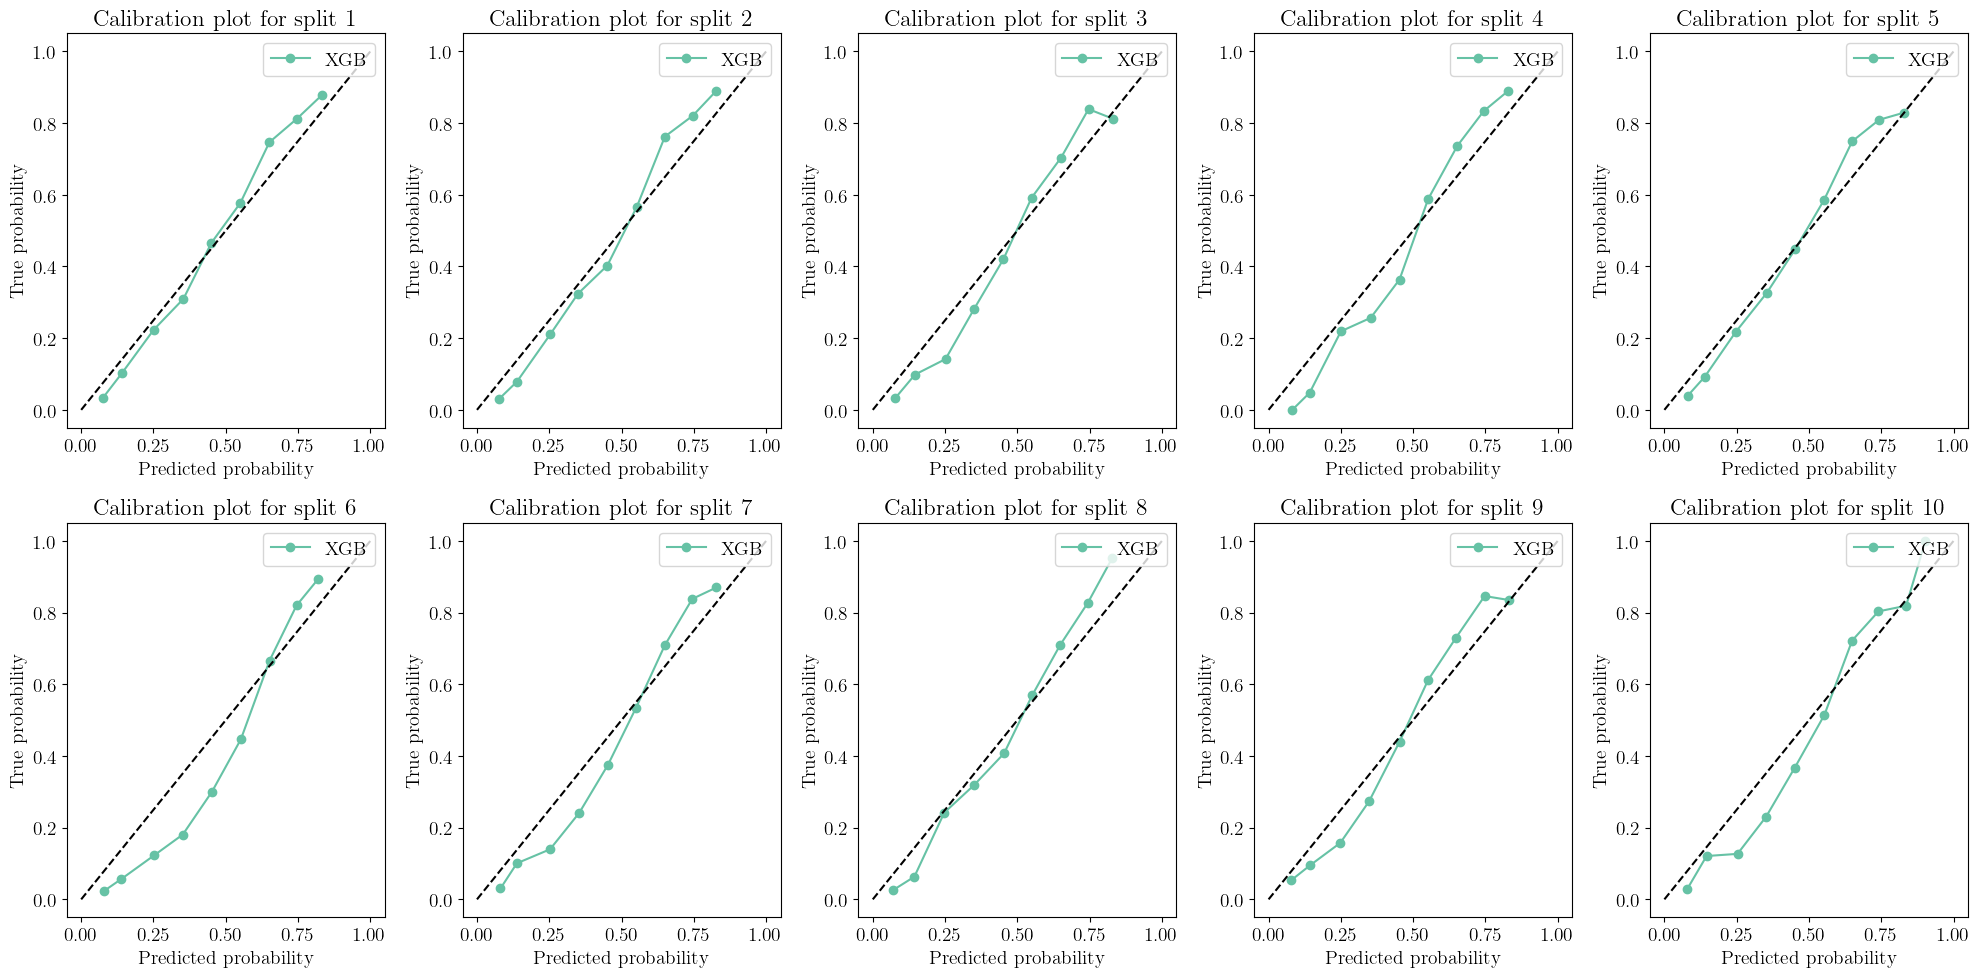

In [56]:
from sklearn.calibration import calibration_curve
dataset_category="TDC"
dataset_names="CYP2C19"
split_type="scaffold"
model_names = ["GCN", "GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax", "randomForest", "SVM", "XGB"]
filename="XGB"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")
# Load your predictions and labels
indices = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(indices):
    df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, filename, str(i + 1), "prediction.csv"))
    y_pred_prob = df["label"].values
    df1 = pd.read_csv(os.path.join(SPLIT_PATH, split_type, f"test_{i}.csv"))
    y_true = df1["label"].values

    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)

    # Plot calibration curve
    ax[i // 5, i % 5].plot(prob_pred, prob_true, marker='o', label=filename)
    ax[i // 5, i % 5].plot([0, 1], [0, 1], linestyle='--', color='black')
    ax[i // 5, i % 5].set_title(f"Calibration plot for split {i + 1}")
    ax[i // 5, i % 5].set_xlabel("Predicted probability")
    ax[i // 5, i % 5].set_ylabel("True probability")
    ax[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()



In [39]:
from sklearn.metrics import brier_score_loss

def brier_score(y_true, y_pred_prob):
    brier_score = brier_score_loss(y_true, y_pred_prob)
    return brier_score

In [40]:
def expected_calibration_error(y_true, y_pred_prob, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred_prob >= bin_lower) & (y_pred_prob < bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            avg_pred_prob_in_bin = np.mean(y_pred_prob[in_bin])
            ece += np.abs(avg_pred_prob_in_bin - accuracy_in_bin) * prop_in_bin

    return ece



In [41]:
# Calculate ECE and Brier Score
ece = expected_calibration_error(y_true, y_pred_prob)
brier = brier_score(y_true, y_pred_prob)
print(f"Expected Calibration Error (ECE): {ece}")
print(f"Brier Score: {brier}")

Expected Calibration Error (ECE): 0.12903160797383967
Brier Score: 0.17273693182161365


In [61]:
# Calculate ECE and Brier Score for all datasets, all models and all splits
import yaml
cfg = yaml.safe_load(open(os.path.join(DATASET_PATH, 'config.yml'), 'r'))

dataset_category="TDC"
dataset_names= cfg["datasets"][dataset_category]
split_types= cfg["splitting"]
model_names = cfg["models"]["ML"] + cfg["models"]["GNN"]["scratch"] + cfg["models"]["GNN"]["pretrained"]

results = []
for dataset in dataset_names:
    for split_type in split_types:
        for model in model_names:
            for i in range(10):
                df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset, split_type, model, str(i + 1), "prediction.csv"))
                y_pred_prob = df["label"].values
                df1 = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset, "split", split_type, f"test_{i}.csv"))
                y_true = df1["label"].values
                ece = expected_calibration_error(y_true, y_pred_prob)
                brier = brier_score(y_true, y_pred_prob)
                results.append({"dataset": dataset, "split": split_type, "model": model, "ECE": ece, "Brier Score": brier})

results = pd.DataFrame(results)


In [71]:
filter_dataset = "AMES"
dataset_results = results[results["dataset"]==filter_dataset]
dataset_results.groupby('split')['ECE'].mean()

split
kmeans               0.085662
max_dissimilarity    0.092433
molecular_weight     0.122156
perimeter            0.077224
scaffold             0.078366
Name: ECE, dtype: float64

## Molecular weight analysis

In [27]:
# First calculate molecular weight for train and test set. Then, break down the test set to three different bins based on molecular weight
# Then, find out the prediction on each bin, and then calculate accuracy for each bin

dataset_category="TDC"
dataset_names="CYP2D6"
split_type="molecular_weight"
model_name="randomForest"
# do that for all index from 1 to 10
index = 1
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

accuracy_list = []
# Load your predictions and labels
for index in range(0, 10):
    df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, model_name, str(index + 1), "prediction.csv"))
    df1 = pd.read_csv(os.path.join(SPLIT_PATH, split_type, f"test_{index}.csv"))

    # Compute molecular weight
    df1["mw"] = df1["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))

    df["prediction"] = df["label"] > 0.5
    df["label"] = df1["label"]

    # Break down the test set to three different bins based on molecular weight
    bins_range = [min(df1["mw"])-0.0001, df1["mw"].quantile(0.4), df1["mw"].quantile(0.8), max(df1["mw"]+0.0001)]

    # Find out the prediction on each bin
    df["mw"] = df1["mw"]
    df["bin"] = pd.cut(df["mw"], bins=bins_range, labels=["low", "medium", "high"])

    # Calculate accuracy for each bin
    accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
    print(f"Accuracy for split {index}")
    accuracy_list.append(accuracy)


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 0


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 1


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 2


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 3


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 4


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 5


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 6


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 7


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


Accuracy for split 8
Accuracy for split 9


/tmp/ipykernel_2646873/3693603998.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
/tmp/ipykernel_2646873/3693603998.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())


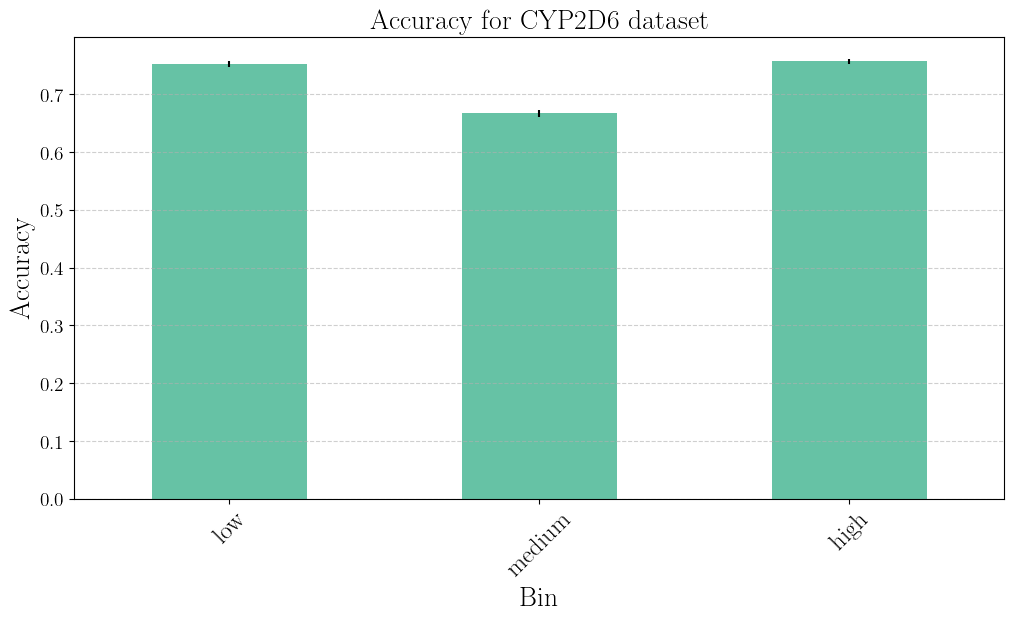

In [28]:
# Plot the accuracy for each bin with mean and standard deviation
accuracy_df = pd.concat(accuracy_list, axis=1).T

# determine mean and standard deviation for each columns and then plot barplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
accuracy_df.mean().plot(kind='bar', ax=ax, yerr=accuracy_df.std())
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Bin", fontsize=20)
plt.title(f"Accuracy for {dataset_names} dataset", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [29]:
df["bin"].value_counts()

bin
low       520
medium    519
high      260
Name: count, dtype: int64

In [30]:
bins_range

[420.2411888719999, 455.1469072224, 515.2034324512, 1663.5023518799992]

# Calculate TMD

In [4]:
# just read the datasets and concatanate their smiles column
dataset_category="TDC"
dataset_names = ["CYP2C19", "CYP2C9", "CYP3A4", "CYP1A2", "HERG", "AMES"]
smiles = []
for dataset in dataset_names:
    df = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset, f"{dataset}_standardize.csv"))
    smiles.append(df["smiles"])
smiles = pd.concat(smiles)



In [8]:
# calculate the unique smiles and keep just the unique smiles
print(f"Number of smiles: {smiles.shape[0]}")
smiles = smiles.drop_duplicates()
print(f"Number of unique smiles: {smiles.shape[0]}")

# save this into three different files with three different chunks of smiles
keep = smiles.shape[0] // 3
smiles[:keep].to_csv(os.path.join(DATASET_PATH,"smiles1.csv"), index=False)
smiles[keep:2*keep].to_csv(os.path.join(DATASET_PATH,"smiles2.csv"), index=False)
smiles[2*keep:].to_csv(os.path.join(DATASET_PATH,"smiles3.csv"), index=False)

Number of smiles: 35847
Number of unique smiles: 35847


In [10]:
smiles.to_csv(os.path.join(DATASET_PATH,"smiles.csv"), index=False)
